In [1]:
!pip install gdown

# Importing Libraries

In [2]:
import gdown
import gensim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Bidirectional, LSTM, Dense, Dropout, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import F1Score

# Importing Data

In [3]:
gdown.download("https://drive.google.com/uc?id=12OqvVFIDZcs1MsG8wJMbu-3zGKEKCLNy", '/kaggle/working/data.csv', quiet=False)
print('/kaggle/working/data.csv')

Downloading...
From: https://drive.google.com/uc?id=12OqvVFIDZcs1MsG8wJMbu-3zGKEKCLNy
To: /kaggle/working/data.csv
100%|██████████| 736k/736k [00:00<00:00, 90.4MB/s]

/kaggle/working/data.csv


In [4]:
df = pd.read_csv("/kaggle/working/data.csv")
df.head()

,text,comp,en1,en2
0,لابتوب اسوس افضل من لابتوبات ابل ؟ احس مستحيل ...,1,اسوس,ابل
1,اسوس افضل من وجهة نظري,1,اسوس,NaN
2,كلهم نفس المواصفات مافي فرق اسوس افضل من hp في...,1,اسوس,hp
3,التخصصات الهندسية بالذات الحاسب والبرمجيات ماي...,1,اسوس,NaN
4,اسوس افضل من ناحية التنوع والاسعار والعروض,1,اسوس,NaN


# Aravec Embedding

In [5]:
!wget https://bakrianoo.ewr1.vultrobjects.com/aravec/full_grams_cbow_300_twitter.zip -O /kaggle/working/full_grams_cbow_300_twitter.zip

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-11-28 16:14:11--  https://bakrianoo.ewr1.vultrobjects.com/aravec/full_grams_cbow_300_twitter.zip
Resolving bakrianoo.ewr1.vultrobjects.com (bakrianoo.ewr1.vultrobjects.com)... 108.61.0.122, 2001:19f0:0:22::100
Connecting to bakrianoo.ewr1.vultrobjects.com (bakrianoo.ewr1.vultrobjects.com)|108.61.0.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3325529808 (3.1G) [application/zip]
Saving to: '/kaggle/working/full_grams_cbow_300_twitter.zip'

/kaggle/working/ful 100%[===================>]   3.10G  17.0MB/s    in 3m 15s  

2024-11-28 16:17:27 (16.3 MB/s) - '/kaggle/working/full_grams_cbow_300_twitter.zip' saved [3325529808/3325529808]



In [6]:
!unzip /kaggle/working/full_grams_cbow_300_twitter.zip -d /kaggle/working/

Archive:  /kaggle/working/full_grams_cbow_300_twitter.zip
  inflating: /kaggle/working/full_grams_cbow_300_twitter.mdl  
  inflating: /kaggle/working/full_grams_cbow_300_twitter.mdl.trainables.syn1neg.npy  
  inflating: /kaggle/working/full_grams_cbow_300_twitter.mdl.wv.vectors.npy  


In [7]:
model_path = '/kaggle/working/full_grams_cbow_300_twitter.mdl'
aravec_model = gensim.models.Word2Vec.load(model_path)

# Data Preprocessing

In [8]:
# Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])

In [9]:
sequences = tokenizer.texts_to_sequences(df['text'])

In [10]:
word_index = tokenizer.word_index
print(f"Number of unique tokens: {len(word_index)}")

Number of unique tokens: 15728


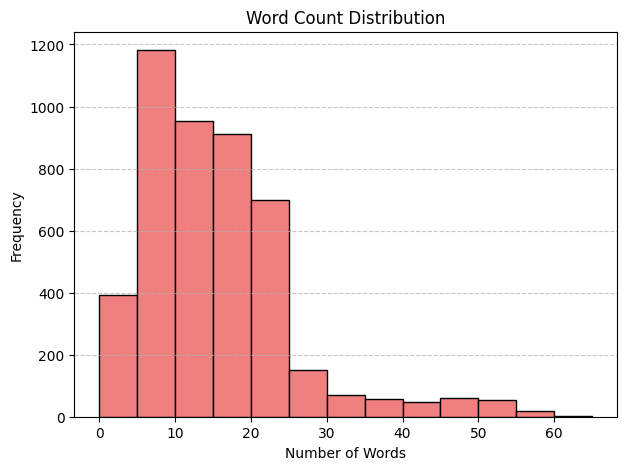

In [11]:
# Calculate word counts
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

# Define bin size and ranges
bins = range(0, df['word_count'].max() + 5, 5)

plt.figure(figsize=(7,5))
plt.hist(df['word_count'], bins=bins, color='lightcoral', edgecolor='black')
plt.title('Word Count Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Drop count column
df = df.drop(columns=['word_count'])

In [12]:
# Padding sequences
maxlen = 30
X_padded = pad_sequences(sequences, maxlen=maxlen)
X_padded.shape

(4599, 30)

In [13]:
# Load AraVec (300 dimensions)
embedding_dim = 300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim)) 

# Populate embedding matrix
for word, i in word_index.items():
    if word in aravec_model.wv:
        embedding_matrix[i] = aravec_model.wv[word]  
    else:
        embedding_matrix[i] = np.zeros(embedding_dim)

print(f"Shape of embedding_matrix: {embedding_matrix.shape}")

Shape of embedding_matrix: (15729, 300)


In [14]:
y = df['comp']

In [15]:
# Split into train and temp
X_train, X_temp, y_train, y_temp = train_test_split(X_padded, y, test_size=0.3, stratify=y)

# Split temp into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

In [16]:
print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}, Test shape: {X_test.shape}")

Train shape: (3219, 30), Val shape: (924, 30), Test shape: (456, 30)


# CNN

In [17]:
# Define the CNN Model
model = Sequential([
    Embedding(input_dim=len(word_index) + 1,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              trainable=False),

    Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)),
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [18]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', F1Score(threshold=.5)])

In [19]:
# Train
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=16,
    validation_data=(X_val, y_val),
    shuffle=True
)

Epoch 1/10


I0000 00:00:1732810713.012727     142 service.cc:145] XLA service 0x77fd08005c00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732810713.012787     142 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 89/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6932 - f1_score: 0.6824 - loss: 7.5482

I0000 00:00:1732810716.264861     142 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


202/202 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.7857 - f1_score: 0.7841 - loss: 6.0992 - val_accuracy: 0.9675 - val_f1_score: 0.9670 - val_loss: 1.5140
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9712 - f1_score: 0.9712 - loss: 1.0868 - val_accuracy: 0.9654 - val_f1_score: 0.9646 - val_loss: 0.4892
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9837 - f1_score: 0.9840 - loss: 0.4051 - val_accuracy: 0.9827 - val_f1_score: 0.9826 - val_loss: 0.3323
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9790 - f1_score: 0.9797 - loss: 0.3181 - val_accuracy: 0.9773 - val_f1_score: 0.9770 - val_loss: 0.3298
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9883 - f1_score: 0.9881 - loss: 0.2640 - val_accuracy: 0.9903 - val_f1_score: 0.9903 - val_loss: 0.2450
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9895 - f1_score: 0.9893 - loss: 0.2324 - val_accuracy: 0.9805 - val_f1_score: 0.9805 - val_los

# Evaluation

In [20]:
# Prediction 
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [21]:
# metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Testing Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Testing Accuracy: 0.99
Precision: 1.00
Recall: 0.99
F1-Score: 0.99


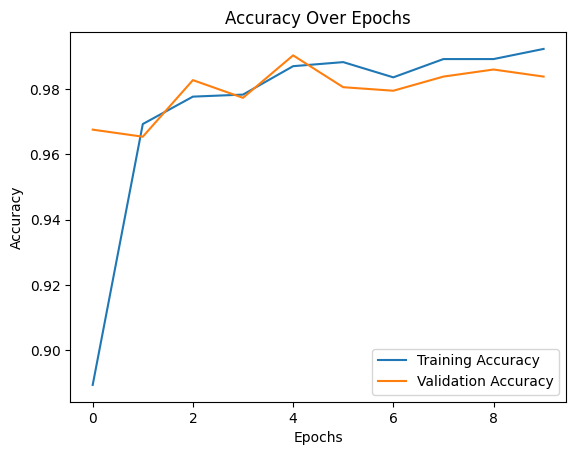

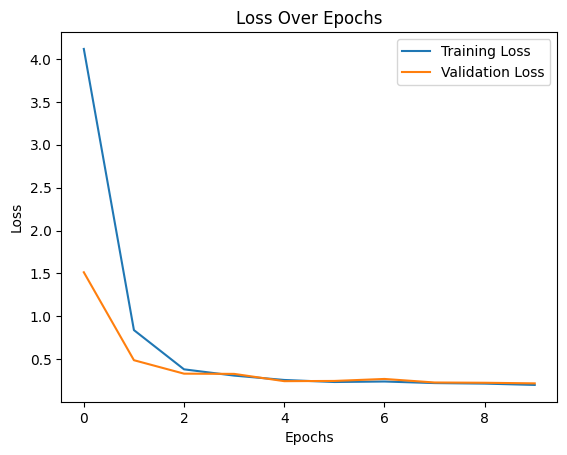

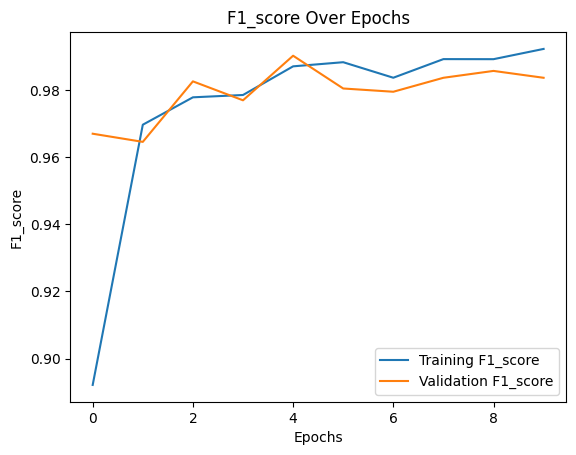

In [22]:
# learning curve
def plot_learning_curves(history):
    metrics = ['accuracy', 'loss', 'f1_score']
    for metric in metrics:
        plt.plot(history.history[metric], label=f'Training {metric.capitalize()}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric.capitalize()}')
        plt.title(f'{metric.capitalize()} Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.show()

plot_learning_curves(history)

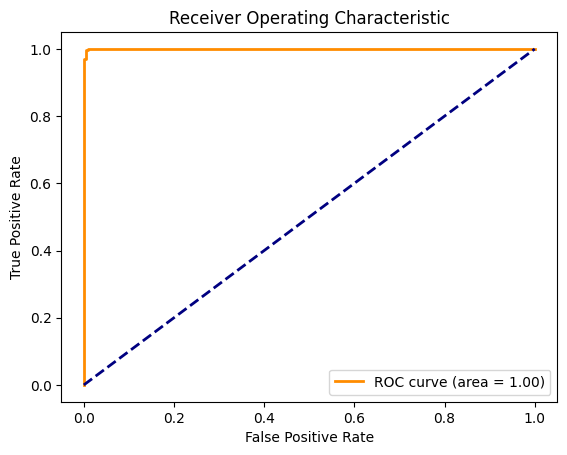

In [23]:
# Predictions and ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

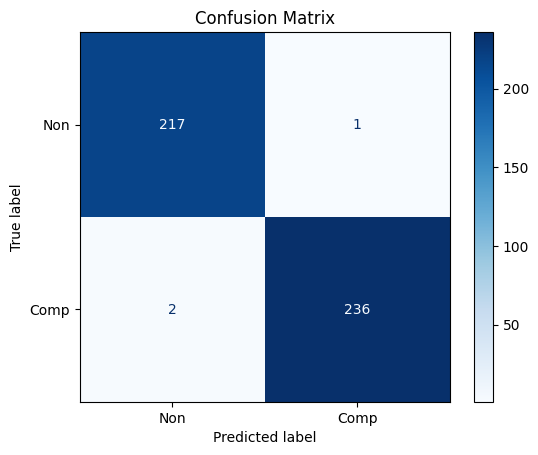

In [24]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Displaying Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non', 'Comp'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()